In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import utils
import matplotlib.pyplot as plt
import so_decadal_variability.calc as socalc
import numpy as np

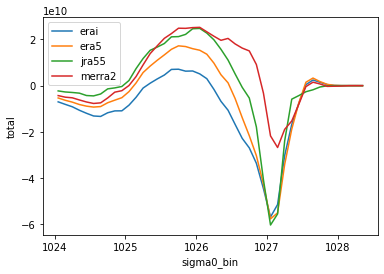

In [3]:
G = {}
# Load observational data
fluxnames=['erai','era5','jra55','merra2']
oceanname='en4'
density = 'sigma0'
dg = 0.1
for fluxname in fluxnames:
    G[fluxname] = xr.open_mfdataset('../../data/processed/'+fluxname+'_'+oceanname+'/G.'+density+'.'+str(dg)+'.*.nc')
    G[fluxname]['total'].mean('time').plot(label=fluxname)
plt.gca().legend()

### Temporal variability : all

/home/aos/graemem/miniconda3/envs/so_decadal_variability/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """
/home/aos/graemem/miniconda3/envs/so_decadal_variability/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """
/home/aos/graemem/miniconda3/envs/so_decadal_variability/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: sh

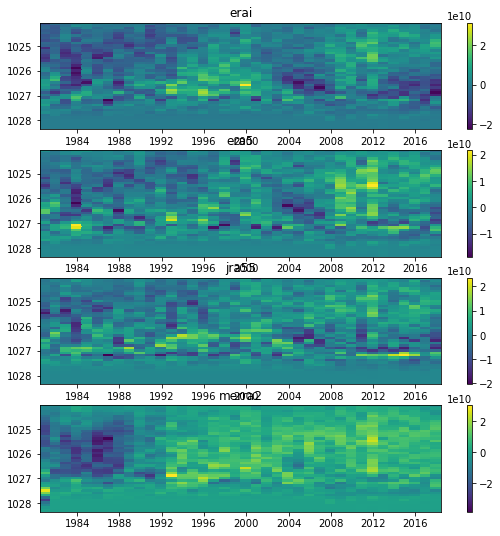

In [4]:
fig, ax = plt.subplots(figsize=(9,9),nrows=len(fluxnames))
for i,fn in enumerate(fluxnames):
    im = ax[i].pcolormesh(socalc._annual(G[fn]['time']),
                     G[fluxname]['sigma0_bin'],
                     socalc._annualanom(G[fn]['total']).transpose())
    ax[i].invert_yaxis()
    ax[i].set_title(fn)
    plt.colorbar(im,ax=ax[i])

### Selecting watermasses

In [50]:
fn = 'era5'
ex = utils.operations.extrema(G[fn]['total'].mean('time'),dim='sigma0_bin')
c = utils.operations.crossing(G[fn]['total'].mean('time'),dim='sigma0_bin')
bounds = np.sort(np.concatenate((c.values, ex['min'].values, ex['max'].values)))

In [51]:
dG = -1*G[fn].diff('sigma0_bin')